In [1]:
import random
import string
from random import randrange
import matplotlib.pyplot as plt
from typing import Dict,Text
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
import duckdb
import json


def generate_user_id():
    return ''.join(random.choices(string.ascii_lowercase +
                             string.digits, k=15))
def get_random_podcast_title(podcasts):
    num = randrange(len(podcasts))
    return podcasts[num]

def get_random_entries(podcasts,num=4300,num_reviews_per_user=11):
    result = []
    count = 1
    user_id =  generate_user_id()
    for i in range(num):   
        if count == num_reviews_per_user:
            user_id =  generate_user_id()
            count = 1
        result.append((user_id,get_random_podcast_title(podcasts),random.randint(1, 5)))
        count += 1
    return result

def get_metrics(data,model):
    metrics = model.evaluate(data, return_dict=True)
    top_100_accuracy = round(metrics['factorized_top_k/top_100_categorical_accuracy'] * 100,2)
    rmse = round(metrics['root_mean_squared_error'],2)
    print("Retrieval top-100 accuracy: {}%".format(top_100_accuracy))
    print("Ranking RMSE: {}".format(rmse))

In [2]:
con = duckdb.connect('database.db')

#PREPARE DATA

podcast_ratings_query = con.sql("select author_id as user_id, podcasts.title as podcast_title,rating from reviews "+ 
        "join categories using (podcast_id) " +
        "join podcasts using (podcast_id) where average_rating >= 0").to_df()

podcast_titles_query = con.sql("select podcasts.title as podcast_title from reviews "+ 
        "join categories using (podcast_id) " +
        "join podcasts using (podcast_id) where average_rating >= 0").to_df()

entries = get_random_entries(podcasts=podcast_ratings_query["podcast_title"].unique())
for entry in entries:
    row = pd.Series(entry, index=podcast_ratings_query.columns)
    podcast_ratings_query = podcast_ratings_query.append(row,ignore_index=True) 

C:\Users\joshg\AppData\Local\Temp\ipykernel_22884\1557362596.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  podcast_ratings_query = podcast_ratings_query.append(row,ignore_index=True)


In [3]:
len(podcast_ratings_query["podcast_title"].unique())

28

In [4]:
podcast_ratings = podcast_ratings_query.to_dict(orient='records')
podcast_titles = podcast_titles_query.to_dict(orient='records')
podcast_ratings_tf = tf.data.Dataset.from_tensor_slices(pd.DataFrame.from_dict(podcast_ratings).to_dict(orient="list"))
podcast_titles_tf = tf.data.Dataset.from_tensor_slices(pd.DataFrame.from_dict(podcast_titles).to_dict(orient="list"))

ratings_tf = podcast_ratings_tf.map(lambda x: {
    "podcast_title": x["podcast_title"],
    "user_id": x["user_id"],
    "user_rating": x["rating"]
})
titles_tf = podcast_titles_tf.map(lambda x: x["podcast_title"])

tf.random.set_seed(42)
shuffled = ratings_tf.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train_len = int(len(shuffled) * (2/3))
test_len = int(len(shuffled) - train_len)

train = shuffled.take(train_len)
test = shuffled.skip(train_len).take(test_len)

podcast_titles = titles_tf.batch(1_000)
user_ids = ratings_tf.batch(1_000_000).map(lambda x: x["user_id"])

unique_podcast_titles = np.unique(np.concatenate(list(podcast_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [111]:
#TRAIN MODEL

class PodcastlensModel(tfrs.Model):

  def __init__(self,rating_weight=1.0, retrieval_weight=1.0):
    super().__init__()
    embedding_dimension = 32
    self.user_model = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    self.podcast_model = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_podcast_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_podcast_titles) + 1, embedding_dimension)
    ])
    
    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics = tfrs.metrics.FactorizedTopK(
            candidates=titles_tf.batch(128).map(self.podcast_model)
          )
    )
    
    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model.
    podcast_embeddings = self.podcast_model(features["podcast_title"])

    return (
        user_embeddings,
        podcast_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, podcast_embeddings], axis=1)
        ),
    )
  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("user_rating")

    user_embeddings, podcast_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, podcast_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

model = PodcastlensModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(100_000).batch(1500).cache()
cached_test = test.batch(1000).cache()

history = model.fit(cached_train, epochs=50)
metrics = model.evaluate(cached_test, return_dict=True)

Epoch 1/50
3/3 [==============================] - 2s 84ms/step - root_mean_squared_error: 3.0112 - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0068 - factorized_top_k/top_10_categorical_accuracy: 0.0104 - factorized_top_k/top_50_categorical_accuracy: 0.0399 - factorized_top_k/top_100_categorical_accuracy: 0.0855 - loss: 6617.7686 - regularization_loss: 0.0000e+00 - total_loss: 6617.7686     
Epoch 2/50
3/3 [==============================] - 0s 84ms/step - root_mean_squared_error: 2.0138 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0092 - factorized_top_k/top_10_categorical_accuracy: 0.0234 - factorized_top_k/top_50_categorical_accuracy: 0.1189 - factorized_top_k/top_100_categorical_accuracy: 0.2595 - loss: 6524.6898 - regularization_loss: 0.0000e+00 - total_loss: 6524.6898
Epoch 3/50
3/3 [==============================] - 0s 85ms/step - root_mean_squared_error: 1.6483 

In [179]:
print("METRICS FOR TRAIN DATA")
get_metrics(cached_train,model)

print("METRICS FOR TEST DATA")
get_metrics(cached_test,model)

METRICS FOR TRAIN DATA
3/3 [==============================] - 0s 108ms/step - root_mean_squared_error: 1.3480 - factorized_top_k/top_1_categorical_accuracy: 0.2246 - factorized_top_k/top_5_categorical_accuracy: 0.3086 - factorized_top_k/top_10_categorical_accuracy: 0.3728 - factorized_top_k/top_50_categorical_accuracy: 0.7749 - factorized_top_k/top_100_categorical_accuracy: 0.9121 - loss: 4968.9329 - regularization_loss: 0.0000e+00 - total_loss: 4968.9329
Retrieval top-100 accuracy: 91.21%
Ranking RMSE: 1.35
METRICS FOR TEST DATA
2/2 [==============================] - 0s 89ms/step - root_mean_squared_error: 1.4642 - factorized_top_k/top_1_categorical_accuracy: 0.0964 - factorized_top_k/top_5_categorical_accuracy: 0.1166 - factorized_top_k/top_10_categorical_accuracy: 0.1325 - factorized_top_k/top_50_categorical_accuracy: 0.2355 - factorized_top_k/top_100_categorical_accuracy: 0.3178 - loss: 6806.7201 - regularization_loss: 0.0000e+00 - total_loss: 6806.7201
Retrieval top-100 accuracy: 

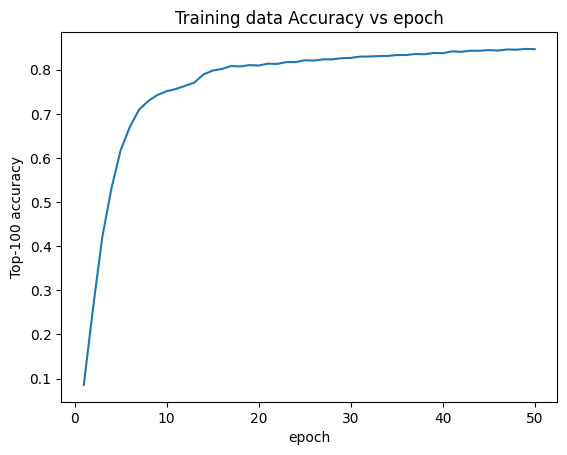

In [122]:
num_validation_runs = len(history.history['factorized_top_k/top_100_categorical_accuracy'])
epochs = [(x + 1) for x in range(num_validation_runs)]

plt.plot(epochs, history.history["factorized_top_k/top_100_categorical_accuracy"])
plt.title("Training data Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.show()

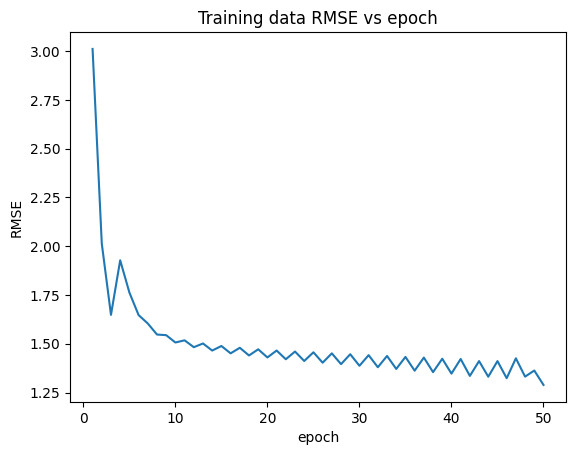

In [121]:
num_validation_runs = len(history.history['root_mean_squared_error'])
epochs = [(x + 1) for x in range(num_validation_runs)]

plt.plot(epochs, history.history["root_mean_squared_error"])
plt.title("Training data RMSE vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.show()

In [123]:
index = tfrs.layers.factorized_top_k.Streaming(model.user_model,k=25)
index.index_from_dataset(
  tf.data.Dataset.zip((titles_tf.batch(1000), titles_tf.batch(100).map(model.podcast_model)))
)

In [124]:
#RUN PREDICTIONS ON TEST DATA 
num = 0 
for element in test:
    user_id = element["user_id"].numpy().decode()
    _, preds = index(tf.constant([user_id]))
    unique_preds = np.unique(preds.numpy())
    unique_preds = [el.decode('UTF-8') for el in unique_preds]
    print("Top {} recommendations for user {}: {}".format(len(unique_preds),user_id,unique_preds))
    print("")
    num += 1
    if num == 5:
        break

Top 6 recommendations for user 7zm8fd9risr1cr1: ['Daily Solutions Podcast', 'Emprendedores Digitales |Marketing Digital, Blogging, Redes Sociales, Marketing Online, Negocios, SEO, blogs, Desarrollo Pers', 'I Crush Barbecue Show', 'Maximiza Tu Negocio en Redes de Mercadeo', 'Nahh B! Podcast MMA / UFC And Boxing Event Preview & Reviews', 'Rebel Chums']

Top 1 recommendations for user a1z9il2l31qy6ol: ['Rekt Podcast']

Top 5 recommendations for user bdl324kyn7e1r9n: ['I Crush Barbecue Show', 'Inglestotal : Cursos y clases gratis de Ingles', 'Last Week at the Movies Podcast', 'Little Realms | A DnD Actual Play Podcast', 'Nahh B! Podcast MMA / UFC And Boxing Event Preview & Reviews']

Top 4 recommendations for user 1a0drgz5ku0ejul: ['Daily Solutions Podcast', 'I Crush Barbecue Show', 'Lost In The Shuffle', 'Rekt Podcast']

Top 1 recommendations for user ecb2b29a0ffa08d: ['Rekt Podcast']

